## NBA Tweets: Natural Language Processing and Network Analysis

MSDA Data 620 Final Project 

Team 4 - John Grando, Nick Capofari, Ken Markus, Armenoush Aslanian-Persico, Andrew Goldberg



In [3]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://raw.githubusercontent.com/spsstudent15/2017-02-620-WebAnalytics/master/nbalogo2.jpg")

### Part 1: Introduction

The NBA has among the most active social media users in the world of professional sports. Players often interact directly with their fans via Twitter, and interact with one another as well. Our analysis pulled tweets from the most active current players on Twitter (identified from fanpagelist.com) and we added a few additional handles of the most active former players, coaches and owners within the NBA network.

We expect to see players associated with a particular team to interact more frequently, and connect with their own team handles especially. We also expect the networks to still resemble typical ‘broadcast’ type structures in that networks in general will be sparse.

<a href="https://github.com/spsstudent15/2017-02-620-WebAnalytics/blob/master/playerList.csv">Click here to view our selected list of Twitter users.</a>


<b>YouTube walkthroughs of project sections are available here:</b>

<a href="https://youtu.be/onedOIidyU0">Data Acquisition</a>

<a href="https://youtu.be/U8qpdvMX3RM">Natural Language Processing Analysis</a>

<a href="">Sentiment and Network Analysis</a>



### Part 2: Data Acquisition


<a href="https://github.com/kennygfm/Data620/blob/master/Team4_FinalProject_buildTwitterDataFrame_V7.9.R">Click here to view the code for this data pull on GitHub.</a>


We collected recent tweets from the most active NBA players (and associates) via the Twitter Search API. The API allows for basic search queries (e.g. to: or from: a specific handle, or containing a specific hashtag). However, there are certain limitations with the public-facing API:

-Results are limited to the last 7 days

-Return sets are limited in size, the documentation states only 7 tweets are returned in each query; however in practice we were able to pull upwards of 50 tweets per query.

An alternative to Twitter’s Search API is their Streaming API, which returns real-time results. We attempted to leverage this option, however the result sets were actually smaller because the players and associates were simply not active enough on Twitter to yield more results.

Once tokens were acquired, performing the data pulls proved relatively simple. We leveraged package SocialMediaLab to facilitate the formatting of the data. This package contains wrappers for Facebook and Instagram APIs in addition to Twitter. The encapsulation of credentials, and formatting of tweet data are the primary benefits.

The output data derives from the twitteR package, of the status-class class.

#### Field data dictionary

The below are variable fields available in the API pull data.

| Variable        | Definition           |
| :------------- |:-------------:| 
| text      | The text of the status. | 
| screenName      | Screenname of the user who posted the status. |
| created | When this status was created. |
| favorited | Whether this status has been favorited. |
| id | ID of the status. |
| replyToSN | Screen name of the user this is in reply to. |
| replyTOUID | ID of the user this was in reply to. |
| retweetCount | The number of times this status has been retweeeted. |
| retweeted | TRUE if this status has been retweeted. |
| statusSource | Source user agent for this tweet. |
| truncated | Whether this status was truncated. |



#### Data Setup and Packages

We imported the following packages for use in this project.

In [4]:
import networkx as nx
import networkx.algorithms
import networkx.algorithms.bipartite as bipartite
import matplotlib.pyplot as plt
import numpy
import pandas as pd
import pylab as py
import nltk
import random

from networkx.algorithms.components.connected import connected_components
from scipy.spatial import distance
from scipy.cluster import hierarchy
from collections import defaultdict

% matplotlib inline

### Part 3: Natural Language Processing Analysis

In this section, we will perform a natural language process analysis of the NBA twitter data. first, we will merge the two data tables created in the previously mentioned R proram. Second, we will break up the twitter data into a usable format. Third, we will create a set of features to analyze the data. Fourth, we will train and test the data. Finally, we will run the analysis on the remaining untested data. For this analysis, we will see if we can predict whether a tweet has come from an active player(Yes), non-active player(No), or a team (Team).

The below image is an example of a team account.

In [5]:
Image(url= "https://raw.githubusercontent.com/spsstudent15/2017-02-620-WebAnalytics/master/twitter-cavs.JPG")

<b>Data Import and Setup</b>

In [6]:
#Read in the previously mentioned R tables

playerdf = pd.read_csv("https://raw.githubusercontent.com/john-grando/Masters/master/DATA620/Week6/playerList.csv", encoding='latin-1')
tweetdf = pd.read_csv("https://raw.githubusercontent.com/john-grando/Masters/master/DATA620/Week6/Top20Tweets_and_Teams_and_Ancillary.csv", encoding='latin-1')

In [7]:

#Join the two tables using the twitter handle as the key.
maindf = tweetdf.merge(playerdf, how='left', left_on="from_user", right_on="handle")

#Check if there are any nulls or NaNs in the joined data.
#print maindf.isnull().sum()

<b>Twitter Data Wrangling</b>

In [8]:
import re
tweetlist = []
for index, row in maindf.iterrows():
    uni_list = []
    word_list = []
    hashtag_list = []
    mention_list = []
    #get just unicode tags
    uni_list = [i for i in re.findall(r'[^\w\s,!@#/\.\:\'\"]', row["text"])]
    #get words
    word_list = [re.sub('[\W]+','', word).lower() for word in row["text"].split() if word[0].isalnum()]
    #get hashtags
    hashtag_list = [word for word in row["text"].split() if word[0].startswith("#")]
    #get mentions
    mention_list = [word for word in row["text"].split() if word[0].startswith("@")]
    #recombine them all and add a tag
    tweetlist.append(((uni_list + word_list + hashtag_list + mention_list, row["retweetCount"], 
                      row["users_mentioned"],row["hashtags_used"]), row["active"]))

<b>Set The Features Function</b>

In [9]:
def twitter_features(tweet, tweetcount, users_mentioned, hashtags_used):
    tweet_words = set(tweet)
    features = {}
    #if nothing is returned from the tweetlist, it's a nan, so I used the isintance(x, float) method to filter.
    #Check if there is more than one user metioned
    if not isinstance(users_mentioned, float):
        if len(users_mentioned.split(","))>1:
            features["num_instances({})".format("mentioned_more_than_one")] = True
        else:
            features["num_instances({})".format("mentioned_more_than_one")] = False
    else:
        features["num_instances({})".format("mentioned_more_than_one")] = False
    #check the number of times tweet was retweeted
    if int(tweetcount) > 1000:
        features["num_instances({})".format("retweet_count_large")] = True
    else:
        features["num_instances({})".format("retweet_count_large")] = False
    #check if more than one hashtag was used
    if not isinstance(hashtags_used, float):
        if len(hashtags_used.split(","))>1:
            features["num_instances({})".format("hashtags_more_than_one")] = True
        else:
            features["num_instances({})".format("hashtags_more_than_one")] = False
    else:
        features["num_instances({})".format("hashtags_more_than_one")] = False
    #Create a feature for each user mentioned
    if not isinstance(users_mentioned, float):
        for i in [um for um in users_mentioned.split(",")]:
            features["mentioned({})".format(str(i).strip())] = True
    #Create a feature for each hashtag used
    if not isinstance(hashtags_used, float):
        for i in [hu for hu in hashtags_used.split(",")]:
            features["hashtag({})".format(str(i).strip())] = True
    return features

<b>Train and Test the Feature Function</b>

In [10]:
#Set the randomizer
random.seed(853)
#shuffle the data
random.shuffle(tweetlist)
#Run the data through the features function to train, and guess, the tags.
featuresets = [(twitter_features(d, rc, um, hu), c) for ((d, rc, um, hu),c) in tweetlist]
train_set, dev_test_set, test_set = featuresets[:200], featuresets[200:400], featuresets[400:]
classifier = nltk.NaiveBayesClassifier.train(train_set)

<b>Check the Accuracy, Crosstab, Specificity, and Sensitivity of the Dev Set</b>

In [11]:
print ('Accuracy:') 
nltk.classify.accuracy(classifier, dev_test_set)
classifier.show_most_informative_features(10)

Accuracy:
Most Informative Features
mentioned(NBASummerLeague) = True             Team : Yes    =      5.3 : 1.0
num_instances(hashtags_more_than_one) = True               No : Yes    =      3.0 : 1.0
num_instances(mentioned_more_than_one) = True             Team : Yes    =      2.7 : 1.0
          mentioned(NBA) = True             Team : Yes    =      2.2 : 1.0
num_instances(retweet_count_large) = True               No : Team   =      2.1 : 1.0
     mentioned(warriors) = True             Team : Yes    =      2.1 : 1.0
    mentioned(KingJames) = True             Team : Yes    =      2.1 : 1.0
  mentioned(FCBarcelona) = True             Team : Yes    =      1.7 : 1.0
num_instances(mentioned_more_than_one) = False             Yes : Team   =      1.3 : 1.0
num_instances(retweet_count_large) = False            Team : No     =      1.3 : 1.0


In [12]:
preds = pd.DataFrame({'observed':[classification for (email,classification) in dev_test_set],
                      'predicted': [classifier.classify(twitter_features(d, rc, um, hu)) 
                                    for ((d, rc, um, hu),c) in tweetlist[200:400]]})

In [13]:
pd.crosstab(preds.observed,preds.predicted)

predicted,No,Team,Yes
observed,,,
No,6,1,9
Team,4,61,36
Yes,4,11,68


In [14]:
#Confusion matrix, Accuracy, sensitivity and specificity
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(preds.observed,preds.predicted)
sensitivity1 = (float(cm[2,2])/(cm[2,2]+cm[0,2]+cm[1,2]))
print('Sensitivity : ', sensitivity1 )

specificity1 = (float(cm[0,0]+cm[0,1]+cm[1,0]+cm[1,1])/(cm[0,0]+cm[0,1]+cm[1,0]+cm[1,1]+cm[0,2]+cm[1,2]))
print('Specificity : ', specificity1)

Sensitivity :  0.601769911504
Specificity :  0.615384615385


<b>Check Against the Non-Development Data</b> 

In [15]:
#print 'Accuracy: %4.2f' 
nltk.classify.accuracy(classifier, test_set)
classifier.show_most_informative_features(10)

Most Informative Features
mentioned(NBASummerLeague) = True             Team : Yes    =      5.3 : 1.0
num_instances(hashtags_more_than_one) = True               No : Yes    =      3.0 : 1.0
num_instances(mentioned_more_than_one) = True             Team : Yes    =      2.7 : 1.0
          mentioned(NBA) = True             Team : Yes    =      2.2 : 1.0
num_instances(retweet_count_large) = True               No : Team   =      2.1 : 1.0
     mentioned(warriors) = True             Team : Yes    =      2.1 : 1.0
    mentioned(KingJames) = True             Team : Yes    =      2.1 : 1.0
  mentioned(FCBarcelona) = True             Team : Yes    =      1.7 : 1.0
num_instances(mentioned_more_than_one) = False             Yes : Team   =      1.3 : 1.0
num_instances(retweet_count_large) = False            Team : No     =      1.3 : 1.0


In [16]:
perf = pd.DataFrame({'observed':[classification for (email,classification) in test_set],
                      'predicted': [classifier.classify(twitter_features(d, rc, um, hu)) 
                                    for ((d, rc, um, hu),c) in tweetlist[400:]]})
pd.crosstab(perf.observed,perf.predicted)

predicted,No,Team,Yes
observed,,,
No,23,9,69
Team,8,333,219
Yes,21,63,465


In [17]:
#Confusion matrix, Accuracy, sensitivity and specificity
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(perf.observed,perf.predicted)
sensitivity1 = (float(cm[2,2])/(cm[2,2]+cm[0,2]+cm[1,2]))
print('Sensitivity : ', sensitivity1 )

specificity1 = (float(cm[0,0]+cm[0,1]+cm[1,0]+cm[1,1])/(cm[0,0]+cm[0,1]+cm[1,0]+cm[1,1]+cm[0,2]+cm[1,2]))
print('Specificity : ', specificity1)

Sensitivity :  0.617529880478
Specificity :  0.564296520424


<b>Check the Triadic Structures Within the Data Set</b> 

In [18]:
#start network analysis
import networkx as net
from IPython.display import display

g = net.MultiDiGraph()
for index, row in maindf.iterrows():
    if not isinstance(row["reply_to"],float) and not row["reply_to"]=="NA":
        #the third entry is how you set the weight
        g.add_edge(row["from_user"],row["reply_to"],row["retweetCount"])
        #display(row["from_user"] + " replied to " + row["reply_to"] + "which had %s retweets" %(row["retweetCount"]))
display(net.triadic_census(g))

{'003': 442413,
 '012': 12002,
 '021C': 0,
 '021D': 2895,
 '021U': 0,
 '030C': 0,
 '030T': 0,
 '102': 0,
 '111D': 0,
 '111U': 0,
 '120C': 0,
 '120D': 0,
 '120U': 0,
 '201': 0,
 '210': 0,
 '300': 0}

From this analysis, we can see that, given the size of the data set, we have created a fairly good predictor of player, or team, status. The development test set returned an accuracy of 66% while the test set returned an accuracy of 62%. 

Additionally, the triadic analysis has shown that the network data set is fairly sparse and many users are not interconnected. The closest this set comes to a closed triad is a structure of 021D, which is not a very good sign of interconnection.

 ### Part 4: Sentiment Analysis

We wanted to run sentiment analysis on tweets to see if positive or negative sentiment could be assessed. 

In [19]:
import twython
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *
import warnings


warnings.filterwarnings("ignore")
tweetwords = []

for index, row in maindf.iterrows():
    sent_list = [re.sub('[\W]+','', word).lower() for word in row["text"].split() if word[0].isalnum()]
    sent = ' '.join(sent_list)
    tweetwords.append([sent, row["from_user"], row["users_mentioned"]])

In [20]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
nltk.download("vader_lexicon")

sia = SIA()
pos_list = []
neg_list = []
rated_sents = []
for post, from_user, users_mentioned in tweetwords:
    res = sia.polarity_scores(post)
    rated_sents.append([post, res['compound'], from_user, users_mentioned]) 

analysisdf = pd.DataFrame(rated_sents, columns = ["post", "sentiment", "from", "to"])
analysisdf[:3]

[nltk_data] Downloading package vader_lexicon to C:\Users\Dom
[nltk_data]     Cobb\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,post,sentiment,from,to
0,so the homie u know what it is g,0.0000,KingJames,RickRoss
1,congrats lil bro httpstcojvhccm6t2t,0.5267,KingJames,"CaldwellPope, KlutchSports"
2,someone get my man shoes and a try out ãââ asa...,0.0000,KingJames,NaN


In [21]:
user_sentiment = analysisdf.groupby("from").mean().sort_values("sentiment", ascending=False)
user_sentiment[:15]

,sentiment
from,
MagicJohnson,0.656468
SHAQ,0.490240
paulpierce34,0.401900
blakegriffin32,0.369467
SpikeLee,0.314833
SteveNash,0.206214
cavs,0.196933
paugasol,0.154590
DwightHoward,0.151242


In [22]:
analysisdf = analysisdf[analysisdf['to'].notnull()]
friend_sent = []
for index, row in analysisdf.iterrows():
        for f in row['to'].split():
            if f in playerdf['handle'].tolist() and f != row['from']:
                friend_sent.append([f, row['from'], row['sentiment'], row['post']])
                
#friend_sent[:3]
friendsentdf = pd.DataFrame(friend_sent, columns = ["to", "from", "sentiment", "post"])
friendssentagdf = friendsentdf.groupby(['to', 'from']).mean().sort_values("sentiment", ascending=False)
friendssentagdf

,,sentiment
to,from,
JHarden13,KingJames,0.5267
KDTrey5,warriors,0.0000
KingJames,World_Wide_Wob,0.0000
MagicJohnson,Lakers,0.0000
StephenCurry30,warriors,0.0000
swish41,SteveNash,0.0000
warriors,cavs,0.0000
CP3,DwyaneWade,-0.2960


Our sentiment analysis showed us that Magic Johnson, Shaq, and Paul Pierce -- all now retired from the NBA -- have the most positive rated tweets.

The algorithm picked up positive sentiment between Lebron James and James Harden, who recently signed a contract extension. There may have been some negative sentiment between Chris Paul and Dwyane Wade, both of whom dissatisfied with their current playing situation.

### Part 5: Network Analysis

Out of 1610 tweets over the time period July 7 to July 18, 2017, 174 tweets contained a mention of a username within the core group of 23 individuals.

Out of those 174 in-network mentions, 59 mentioned another unique user. The remainder of the in-network mentions were a reply-all, or thread, format, which included the original username. 

Therefore, 59 out of the 1610 tweets were true in-network connections.

#### Summary of network statistics

The below are communication exchanges within the core network.

| Tweet From - Tweet To       | Count of Tweets           |
| :------------- |:-------------:| 
| cavs-KingJames | 11 |
| cavs-warriors | 1 |
| DwyaneWade-CP3 | 1 |
| KDTrey5-warriors | 4 |
| KingJames-JHarden13 | 2 |
| Lakers-MagicJohnson | 3 |
| SteveNash-swish41 | 5 |
| warriors-KDTrey5 | 4 |
| warriors-StephenCurry30 | 27 |
| World_Wide_Wob-KingJames | 1 |

These all appear to be directed exchanges with the exception of one pair, KDTrey5-warriors and warriors-KDTrey5.

The below image is an example of an in-network interaction.

In [23]:
Image(url='https://raw.githubusercontent.com/spsstudent15/2017-02-620-WebAnalytics/master/twitter-curry.JPG')

#### Network graph

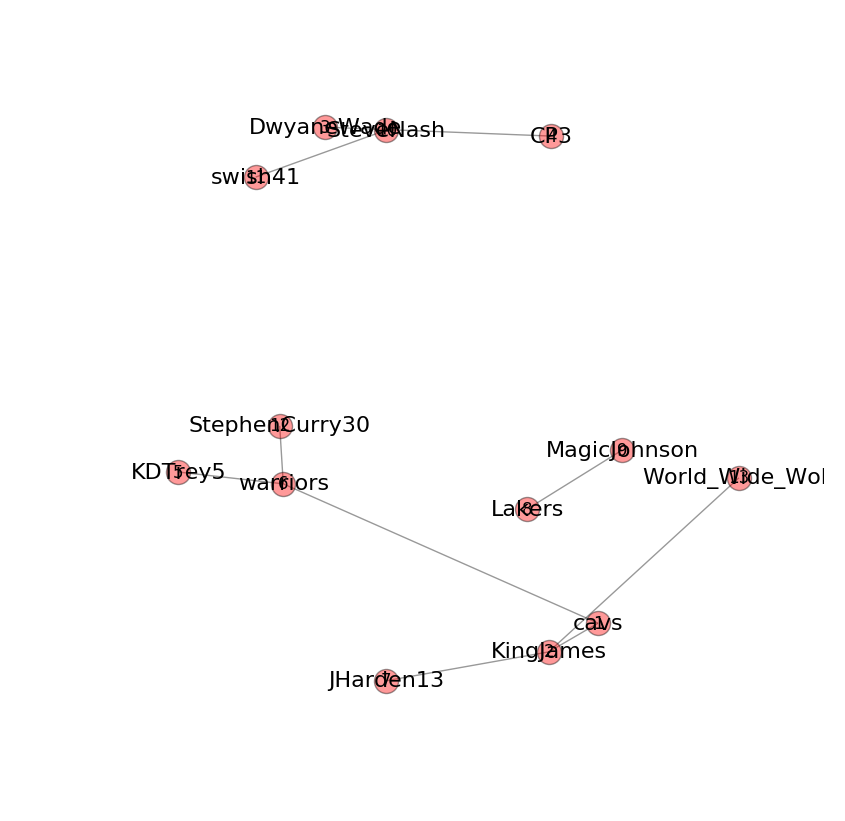

In [24]:
#set figure size and axes
plt.figure(figsize = (10, 10))
plt.axis('off')

#define G
G = nx.Graph()
G.add_nodes_from([1,2,3,4,5,6,7,8,9,10,11,12,13])
G.add_edges_from([(1,2),(1,6),(3,4),(5,6),(2,7),(8,9),(10,11),(6,12),(13,2)])


G.edge[1][2]['weight'] = 11
G.edge[1][6]['weight'] = 1
G.edge[3][4]['weight'] = 1
G.edge[5][6]['weight'] = 8
G.edge[2][7]['weight'] = 2
G.edge[8][9]['weight'] = 3
G.edge[10][11]['weight'] = 5
G.edge[6][12]['weight'] = 27
G.edge[13][2]['weight'] = 1

labels={}
labels[1]='cavs'
labels[2]='KingJames'
labels[3]='DwyaneWade'
labels[4]='CP3'
labels[5]='KDTrey5'
labels[6]='warriors'
labels[7]='JHarden13'
labels[8]='Lakers'
labels[9]='MagicJohnson'
labels[10]='SteveNash'
labels[11]='swish41'
labels[12]='StephenCurry30'
labels[13]='World_Wide_Wob'

pos=nx.spring_layout(G)
nx.draw_networkx(G, pos, alpha=0.4)
nx.draw_networkx_labels(G,pos,labels,font_size=16);



#### Network graph with weighted edges

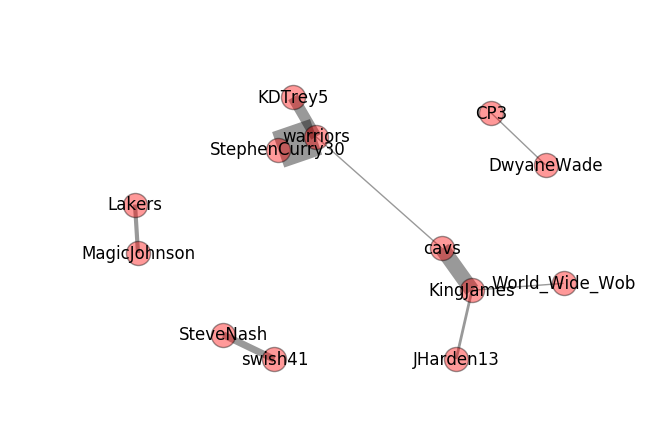

In [25]:
G = nx.Graph()
G.add_edge(1,2,weight=11)
G.add_edge(1,6,weight=1)
G.add_edge(3,4,weight=1)
G.add_edge(5,6,weight=8)
G.add_edge(2,7,weight=2)
G.add_edge(8,9,weight=3)
G.add_edge(10,11,weight=5)
G.add_edge(6,12,weight=27)
G.add_edge(13,2,weight=1)

labels={}
labels[1]='cavs'
labels[2]='KingJames'
labels[3]='DwyaneWade'
labels[4]='CP3'
labels[5]='KDTrey5'
labels[6]='warriors'
labels[7]='JHarden13'
labels[8]='Lakers'
labels[9]='MagicJohnson'
labels[10]='SteveNash'
labels[11]='swish41'
labels[12]='StephenCurry30'
labels[13]='World_Wide_Wob'


pos=nx.spring_layout(G)

edges = G.edges()
weights = [G[u][v]['weight'] for u,v in edges]

nx.draw(G, pos, labels=labels, edges=edges, width=weights, alpha=0.4)

#### Test if the graph is connected.

The graph is not connected, as evidenced by the tweet replies and mentions.

In [26]:
nx.is_connected(G) 

False

#### Show the number of nodes and edges and the average degree.

In [27]:
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 13
Number of edges: 9
Average degree:   1.3846


The average degree connectivity is the average nearest neighbor degree of nodes with degree k. 

The graph is not connected. Therefore, we cannot find a measure for center, diameter, and radius.

#### Show measures for centrality.

In [28]:
nx.betweenness_centrality(G)

{1: 0.13636363636363635,
 2: 0.13636363636363635,
 3: 0.0,
 4: 0.0,
 5: 0.0,
 6: 0.13636363636363635,
 7: 0.0,
 8: 0.0,
 9: 0.0,
 10: 0.0,
 11: 0.0,
 12: 0.0,
 13: 0.0}

#### Results

Out of our select group of users, we see that the cavs, KingJames, and warriors accounts have the greatest centrality.

#### Further Network Analysis

We also tested the expanded network by evaluating all NBA players and their followers. 

<a href="https://github.com/aagoldberg/Web-Analytics/blob/master/Final_Project.ipynb">Click here to view the code for this network analysis on GitHub.</a>


### Part 6: Conclusion


The data was pulled during the offseason, between July 12 and July 17, so activity is relatively low. An interesting follow-up would be to re-run the data pulls and code during playoffs for the regular season and compare the results.


[Brief summary of each section; explanation of what we learned; comparison to what we predicted; technical and conceptual challenges we faced] 
